#### Titanic LightGBM classifier
###### 1. สามารถทำงานร่วมกันกับ categorical data ได้โดยตรง โดยไม่ต้องไปทำ One-hot encoder
###### 2. สามารถจัดการ missing value ได้ โดยไม่ต้อง impute data

In [5]:
import math
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
import warnings
warnings.filterwarnings('ignore')

#### 1.1 utility function

In [7]:
def df_unique_value(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            print(f'{c:10}\n{df[c].unique()}')
            print('-' *65)

def convert_cols_to_category(df, cols:list):
    """
    convert 'cols' to 'category'
    """

    for c in df[cols]:
        df[c] = df[c].astype('category')
    return df

def convert_obj_columns_to_category(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type =='object' or col_type.name == 'category':
            df[c] = df[c].astype('category')
    return df

def print_category_columns(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type.name == 'category':
                # print(f'{c}: {df[c].cat.categories}')
                # print(pd.Series(df[c].cat.categories))
            print(f'{c:15}: {list(enumerate(df[c].cat.categories))}')
            print('-' * 60)

def plot_mn(df, cols, n_rows:int=1, kind:str='boxplot', color='salmon'):
    """
    plot boxplot, violin, hist, in m (rows) by n (columns)
    >>> plot_mn(df, ['Calories', 'Fat'], 2, 'hist')
    """
    n = len(cols)
    n_cols = math.ceil(n/n_rows)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*4))
    ax=ax.ravel()

    fig.tight_layout()
    for i, c in enumerate(cols):
        col_type =df[c].dtype
        if col_type.name == 'category':
            sns.countplot(data=df, x=c, ax=ax[i])
        else:
            if kind.lower()=='boxplot':
                sns.boxplot(data=df[[c]], ax=ax[i], color=color)
            elif kind.lower()=='violin':
                sns.violinplot(data=df[[c]], ax=ax[i], color=color)
            elif kind.lower()=='hist':
                sns.distplot(df[c], hist=True, kde=False, ax=ax[i], color=color)

In [8]:
url = 'https://raw.githubusercontent.com/prasertcbs/basic-dataset/master/titanic_train.csv'
df = pd.read_csv(url)
df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
834,835,0,3,"Allum, Mr. Owen George",male,18.0,0,0,2223,8.3000,NaN,S
507,508,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,NaN,0,0,111427,26.5500,NaN,S
801,802,1,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S
533,534,1,3,"Peter, Mrs. Catherine (Catherine Rizk)",female,NaN,0,2,2668,22.3583,NaN,C
785,786,0,3,"Harmer, Mr. Abraham (David Lishin)",male,25.0,0,0,374887,7.2500,NaN,S
388,389,0,3,"Sadlier, Mr. Matthew",male,NaN,0,0,367655,7.7292,NaN,Q
768,769,0,3,"Moran, Mr. Daniel J",male,NaN,1,0,371110,24.1500,NaN,Q
777,778,1,3,"Emanuel, Miss. Virginia Ethel",female,5.0,0,0,364516,12.4750,NaN,S
93,94,0,3,"Dean, Mr. Bertram Frank",male,26.0,1,2,C.A. 2315,20.5750,NaN,S
699,700,0,3,"Humblen, Mr. Adolf Mathias Nicolai Olsen",male,42.0,0,0,348121,7.6500,F G63,S


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### 1.2.1 convert obj/string columns to category data type for lightGBM

In [10]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
cols_to_cat = ['Pclass','Sex','Embarked']

convert_cols_to_category(df, cols_to_cat)
print_category_columns(df)

Pclass         : [(0, 1), (1, 2), (2, 3)]
------------------------------------------------------------
Sex            : [(0, 'female'), (1, 'male')]
------------------------------------------------------------
Embarked       : [(0, 'C'), (1, 'Q'), (2, 'S')]
------------------------------------------------------------


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(3), float64(2), int64(4), object(3)
memory usage: 65.8+ KB


In [13]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

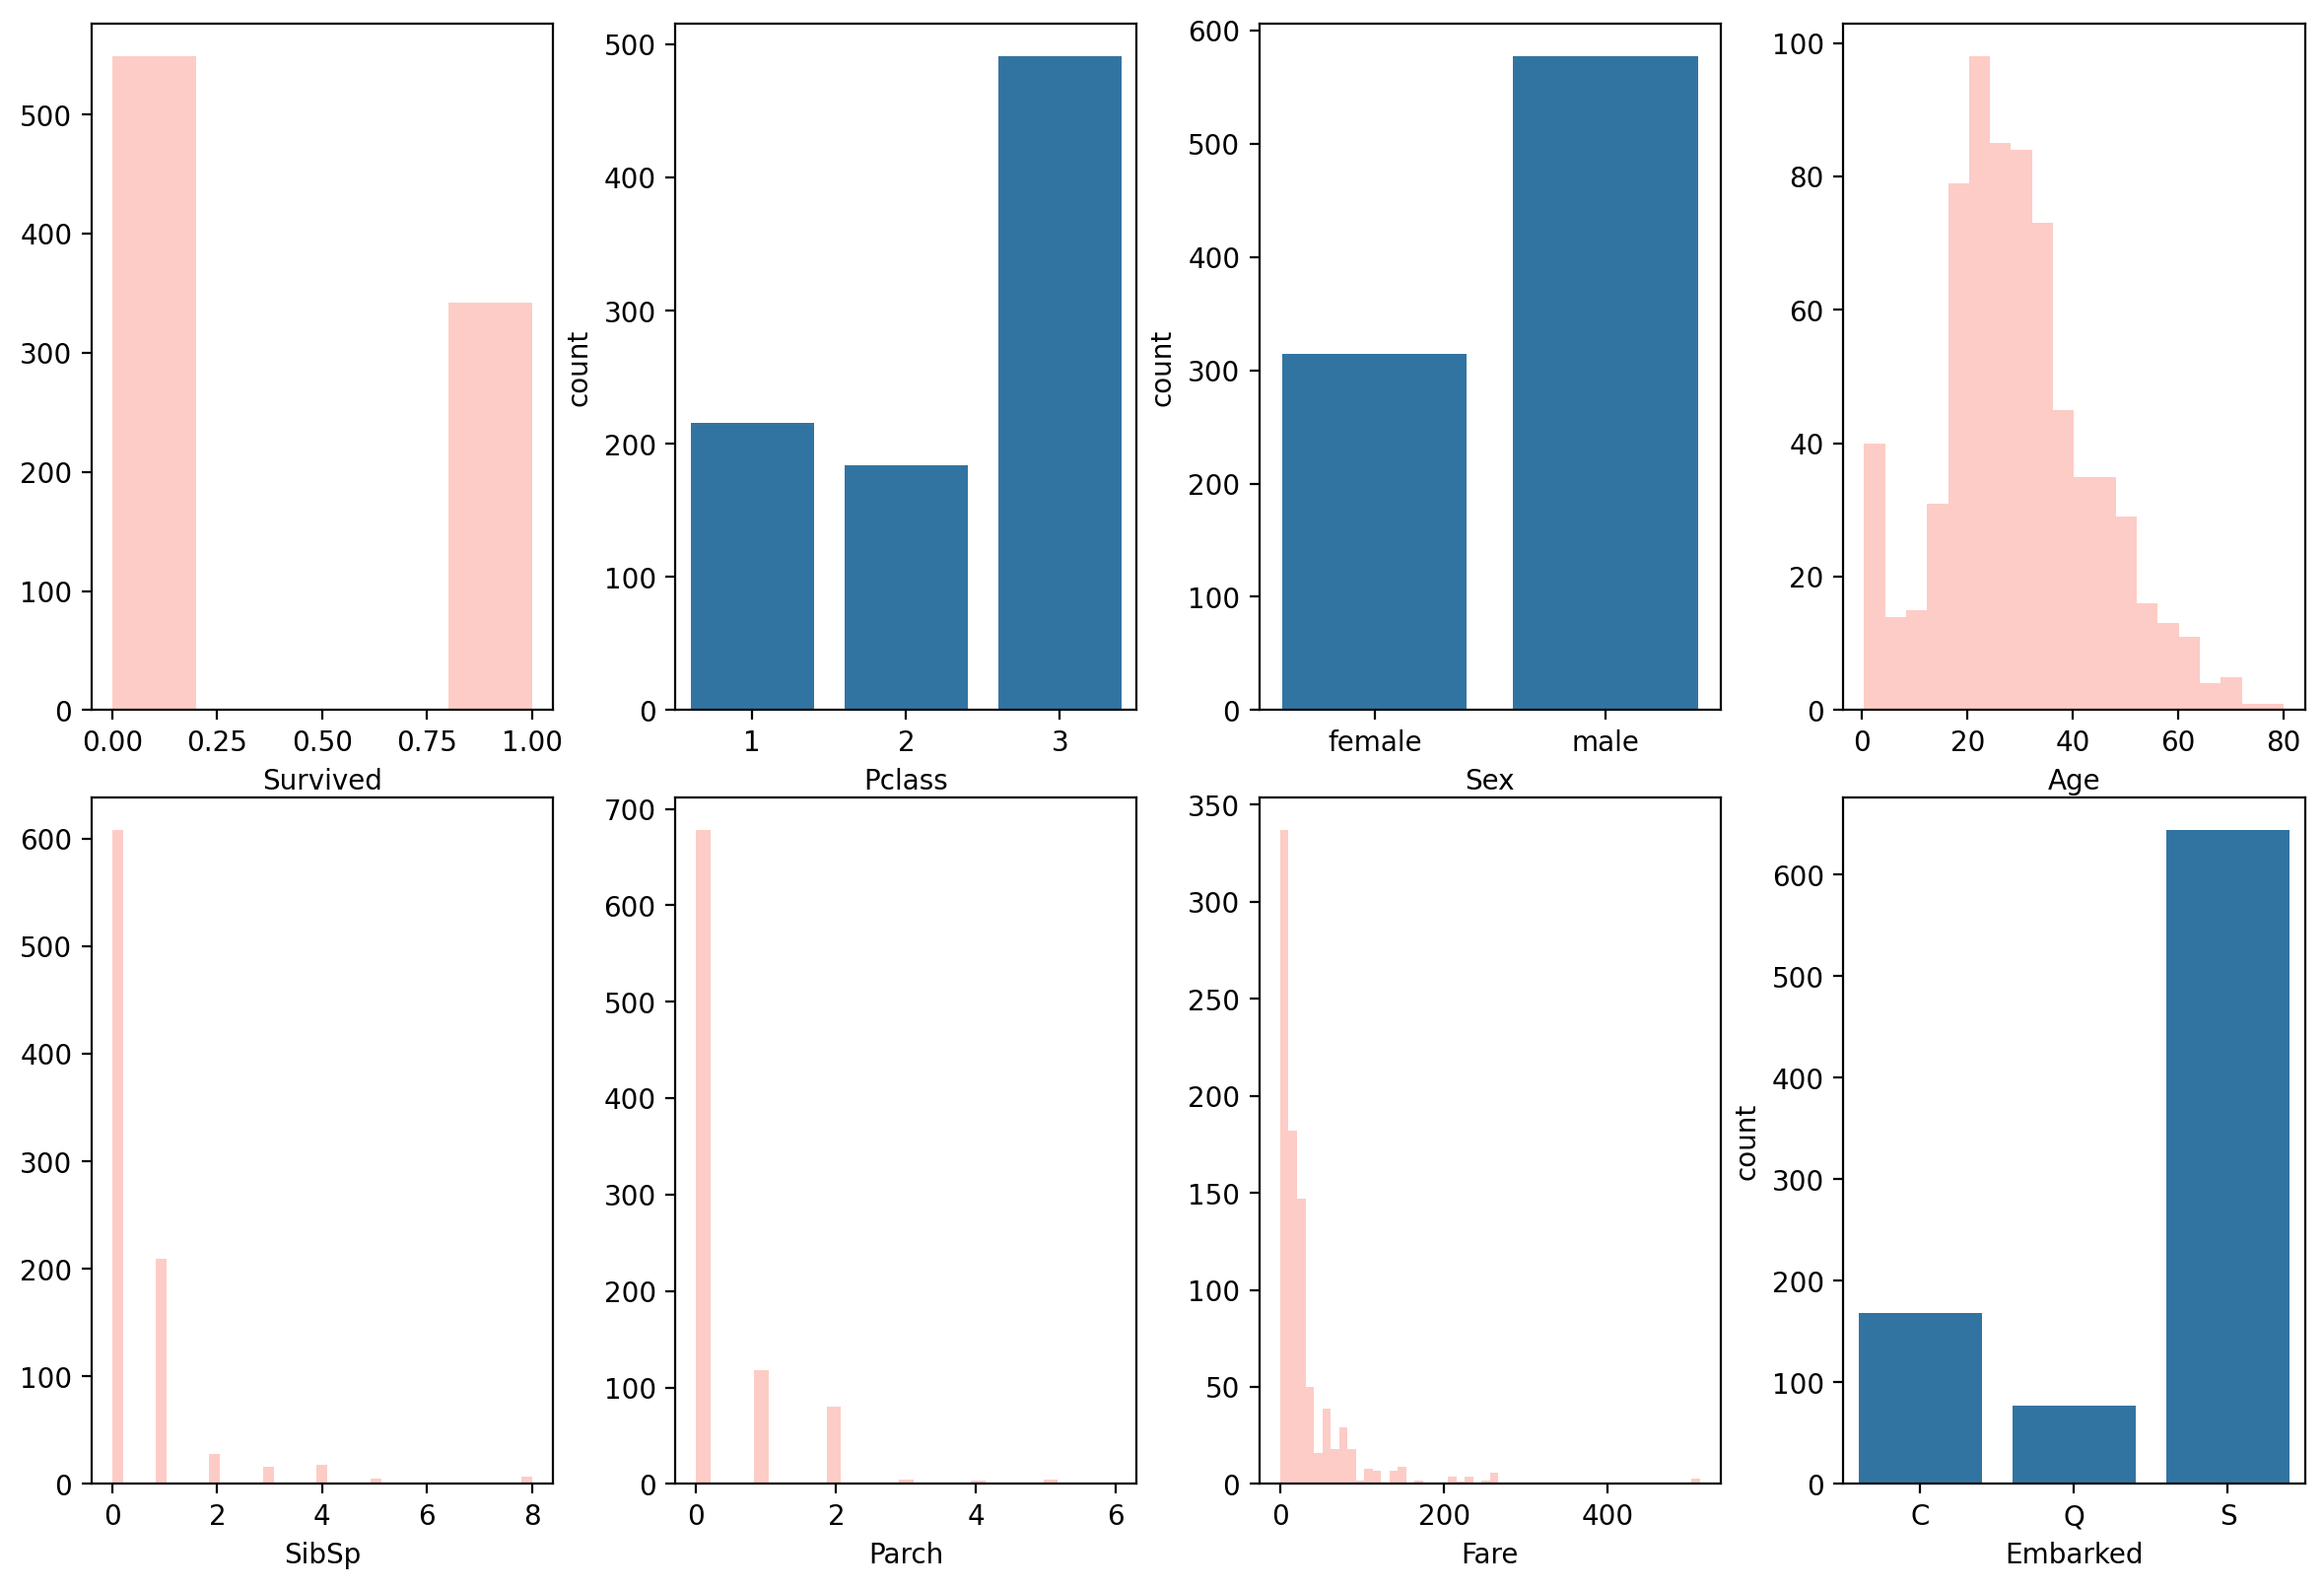

In [14]:
cols = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked']
plot_mn(df, cols, 2, 'hist')

#### 1.3. lightGBM

In [15]:
! pip install -U lightgbm


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import lightgbm as lgb

In [17]:
from lightgbm import early_stopping

In [18]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, cross_val_score, cross_val_predict, cross_validate
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import  LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier
# from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, f1_score

In [19]:
df[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
feature_cols=['Pclass','Sex','Age','SibSp','Parch']
target_col='Survived'

X=df[feature_cols]
y=df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y
                                                )

In [21]:
# Splitting the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [22]:
y_train.value_counts()

Survived
0    352
1    217
Name: count, dtype: int64

In [23]:
# Creating LightGBM datasets
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

In [24]:
# Defining parameters
params = {
    "objective": "binary",
    "metric": "auc"
}

In [25]:
clf = lgb.LGBMClassifier(verbosity=10)

In [26]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': 10}

In [27]:
# tuning parameters: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# https://sites.google.com/view/lauraaepp/parameters
params={'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'silent':True,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

 # clf = lgb.LGBMClassifier(**params)

In [28]:
model = clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(100)]
)

[LightGBM] [Info] Number of positive: 217, number of negative: 352
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.722320
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.409139
[LightGBM] [Debug] init for col-wise cost 0.000074 seconds, init for row-wise cost 0.000081 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.381371 -> initscore=-0.483734
[LightGBM] [Info] Start training from score -0.483734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 9
Training

In [29]:
y_pred = model.predict(X_test)

In [30]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0], dtype=int64)

In [31]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8268156424581006


In [32]:
clf.__dict__

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.0,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'random_state': None,
 'n_jobs': None,
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x211416cbf70>,
 '_evals_result': {'valid_0': OrderedDict([('auc',
                [0.8235837438423645,
                 0.8260467980295566,
                 0.8274835796387521,
                 0.8255336617405583,
                 0.8299466338259441,
                 0.8305623973727422,
                 0.8306650246305419,
                 0.8319991789819376,
                 0.8342569786535303,
                 0.8338464696223317,
                 0.8374384236453202,
                 0.8404146141215106,
                 0.8408251231527094,
 

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

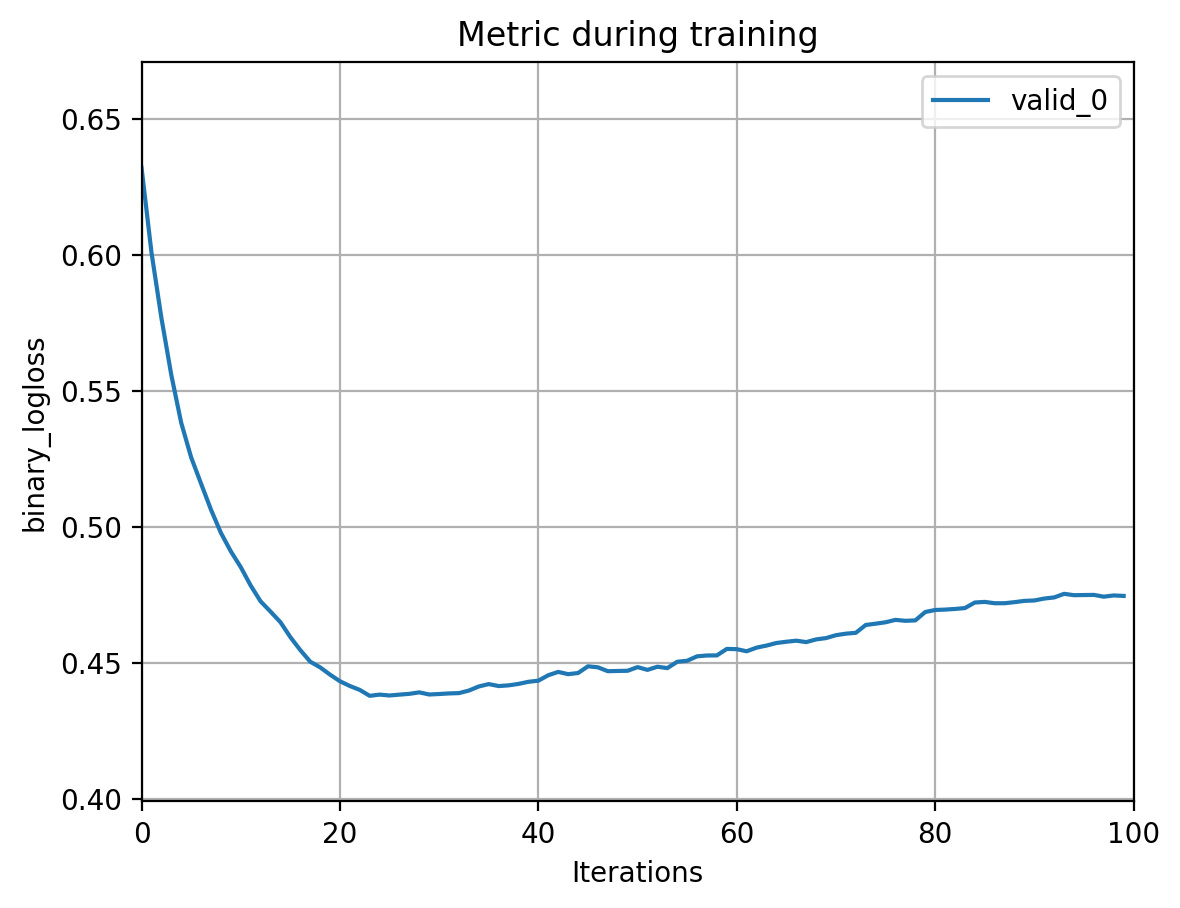

In [33]:
lgb.plot_metric(clf, metric='binary_logloss')

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

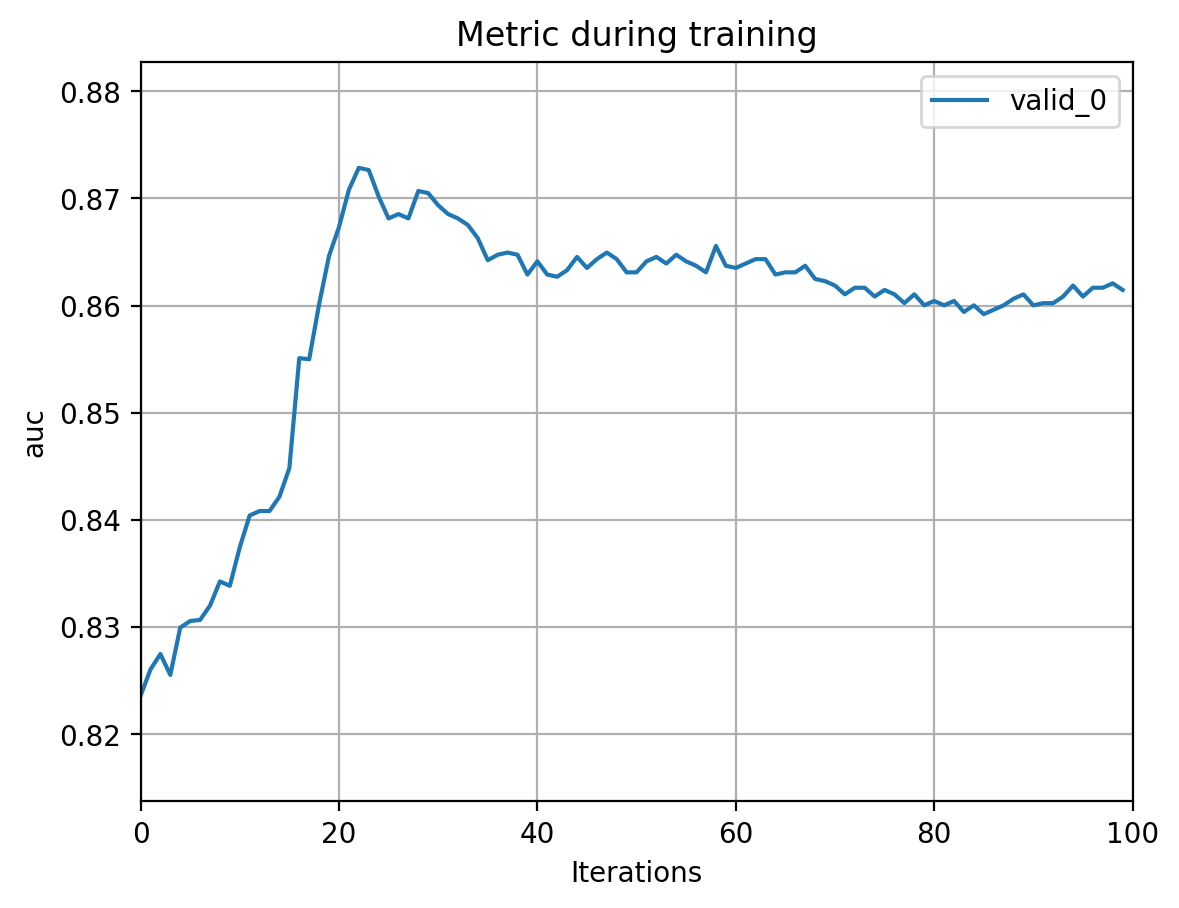

In [34]:
lgb.plot_metric(clf, metric='auc')

In [35]:
clf.score(X_train, y_train) # classification accuracy score

0.8558875219683656

In [36]:
clf.score(X_test, y_test) # classification accuracy score

0.8268156424581006

In [37]:
clf.predict(X_test)[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
      dtype=int64)

In [38]:
clf.predict_proba(X_test)[:20]

array([[0.89503541, 0.10496459],
       [0.7357591 , 0.2642409 ],
       [0.79574586, 0.20425414],
       [0.95368712, 0.04631288],
       [0.84693545, 0.15306455],
       [0.89503541, 0.10496459],
       [0.81534686, 0.18465314],
       [0.78768442, 0.21231558],
       [0.9417439 , 0.0582561 ],
       [0.88528023, 0.11471977],
       [0.13004022, 0.86995978],
       [0.78768442, 0.21231558],
       [0.73413533, 0.26586467],
       [0.90223608, 0.09776392],
       [0.0581922 , 0.9418078 ],
       [0.73623429, 0.26376571],
       [0.85697048, 0.14302952],
       [0.07576286, 0.92423714],
       [0.57077988, 0.42922012],
       [0.9417439 , 0.0582561 ]])

#### 1.3.1 Confusion matrix

In [39]:
cm = confusion_matrix(y_test, clf.predict(X_test))
cm

array([[102,   8],
       [ 23,  46]], dtype=int64)

In [40]:
import sklearn
print(sklearn.__version__)

1.4.0


In [41]:
from sklearn.metrics import plot_confusion_matrix

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (c:\Users\1000259375\Desktop\DE Project\PythonMLBasic\env\lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
plt.rcParams['font.size']=13
plot_confusion_matrix(clf, X_test, y_test, cmap='Oranges', display_labels=['dead', 'survived'])

NameError: name 'plot_confusion_matrix' is not defined

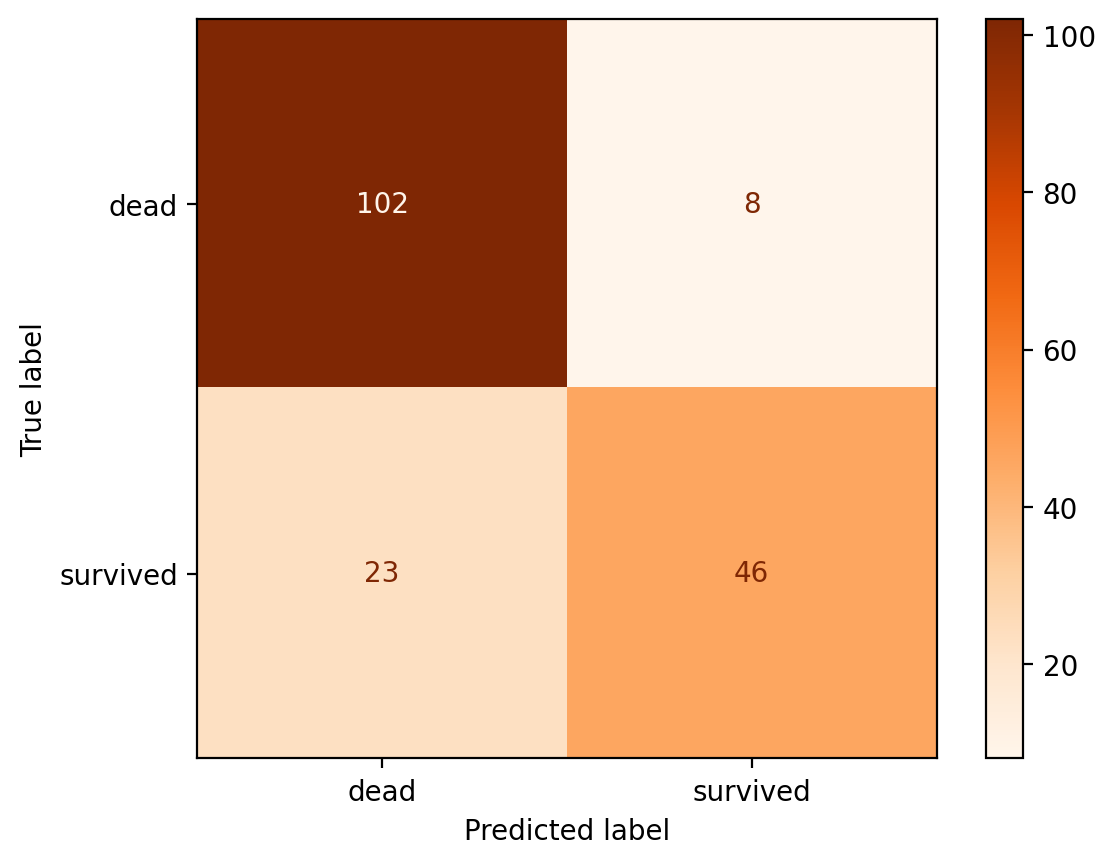

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming clf is your classifier, X_test is your test data, and y_test is your test labels
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['dead', 'survived'])
disp.plot(cmap='Oranges')
plt.show()

In [43]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       352
           1       0.87      0.73      0.80       217

    accuracy                           0.86       569
   macro avg       0.86      0.83      0.84       569
weighted avg       0.86      0.86      0.85       569



In [44]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       110
           1       0.85      0.67      0.75        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179

